### The model and its parameters

In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib as mpl
import os
import pylab as p

os.chdir('C:/Users/user/Desktop')   # sets the cwd to C:/.../HCV (change as needed)

%matplotlib inline

# Initial Conditions ---------------------------------------------------------------------------

NY = 8.6/327.7                          # fraction of the US pop. in New York City
S0 = NY*(1-0.43126)*6.612488*10**6      # Number of PWID in the US from White et al. the (1-0.4126) represents the fraction of PWID who are not infect
IE0 = 0*NY*0.25*0.43126*6.612488*10**6  # US population (here we assume a 75/25 split from https://www.hepatitis.va.gov/patient/faqs/how-does-hepatitisC-progress.asp) the 0.43126 comes from White et al.
IL0 = 0*NY*0.75*0.43126*6.612488*10**6
T0 = NY*0.04*(IE0 + IL0)                # only between 3% and 4% of IDU ever get treatment (Martin et al.)
R0 = NY*0.02*S0                         # this doesn't affect any dynamics but I nonethless chose a small percentage bc few recover
alpha = (IE0+IL0)/(IE0+IL0+S0)
Nu0 = NY * 10**7                        # demand is something like 13 million needles per day so I chose a factor of ten higher for the total number of unifected needles
Ni0 = 1000*Nu0
# Ni0 = Nu0*alpha/(1-alpha)             # comment in if assuming that infected needles are in proportion to infected people


# HCV model data -------------------------------------------------------------------------------

D = 10*10**3                      # number of days
N = 10**5                         # number of time steps
piS = 300                         # susceptible (IDU) birth rate (day^-1)      
muN = 2.735*10**-4                # cessation and HCV death rate percentage (day^-1) (Martin Optimal Control, ref. no. [44]) 
mu = muN                          # mu will be the overall death/cessation rate used
muL = mu                          # death rate of late infected (day^-1) (Singal et al.)
muT = muN                         # percentage of deaths after treatment (assumed to be the natural death rate)
omega = 0.5                       # conversion rate from early to late infected (day^-1) (i.e. we are assuming that 30% of early go to late per day (made up)
# omega = -log(1-omega)           # comment in to use log based parameter
gamma = 2.5                       # IDU usage rate of CLEAN needles (2 - 5 injections per day)
c = 1                             # sharing rate of needles (clean or otherwise) per day per capita
beta = 0.018                      # transmission coefficient (odds that an infected needle infects a user after an injection)
tau = 0.04                        # proportion treated per day (day^-1) 
phi = 0.26                        # self-clearance probability per day (day^-1) (origin? Martin says about a quarter)
# phi = -log(1-phi)               # comment in to use log based parameter
sigma = 0.63                      # proportion of succesful treatments per day (assumed to be probability of treatment success)
piN = 8000                        # introduction rate of new/clean needles into population (day^-1)
zeta = 0.25                       # Odds of infected IDU-user shedding enough virus on a needle to render it infectious 
Ku = 0.301                        # unifected needle proportion discard rate (day^-1)
Ki = 0.301                        # infected needle proportional discard rate (day^-1)
lmbdaT = 4.5*30                   # average number of days for HCV treatment
lmbdaN = 25/24                    # lifetime of HCV in a needle in days 
epsln = 1/lmbdaN                  # proportion of needles becoming uninfected after a day (here I assumed that 4% of needles stay infected after a day)
# epsln = -log(1-epsln)           # comment in to use log based parameter
LmbdaN = 1 - 1/lmbdaN
LmbdaT = 1 - 1/lmbdaT
piT = 25
piI = 40


def dXdt(X,t=0):                  # This function gives the derivatives of the appropriate populations @ a given time step
    S = X[0]
    IE = X[1]
    IL = X[2]
    T = X[3]
    R = X[4]
    Nu = X[5]
    Ni = X[6]

    dSdt = piS + phi * (IE + IL) - c * beta * S * Ni/(Ni + Nu) - mu * S 
    dIEdt = piI + c * beta * S * Ni/(Ni + Nu)  - IE * (omega + tau + mu + phi)   
    dILdt = piT + IE * omega - IL * (mu + tau + phi)
    dTdt = tau * LmbdaT * (IE + IL) - mu * T 
    dRdt = (sigma * tau / lmbdaT) * (IE + IL) - mu * R
    dNudt = piN  - Ku * Nu - gamma * zeta * (IE + IL) * Nu/(Ni + Nu) + epsln * Ni
    dNidt = gamma * zeta * (IE + IL) * Nu/(Ni + Nu) - Ki * Ni - epsln * Ni

    return np.array([dSdt,dIEdt,dILdt,dTdt,dRdt,dNudt,dNidt])


X0 = [S0,IE0,IL0,T0,R0,Nu0,Ni0]    # These are our initial conditions for the populations
t = np.linspace(0,D,N)                # Initializing the time over which to integrate (be mindful of the limits)
Y = odeint(dXdt,X0,t)


S = Y[:,0]
IE = Y[:,1]
IL = Y[:,2]
T = Y[:,3]
R = Y[:,4]
Nu = Y[:,5]
Ni = Y[:,6]






### Plotting the population dynamics

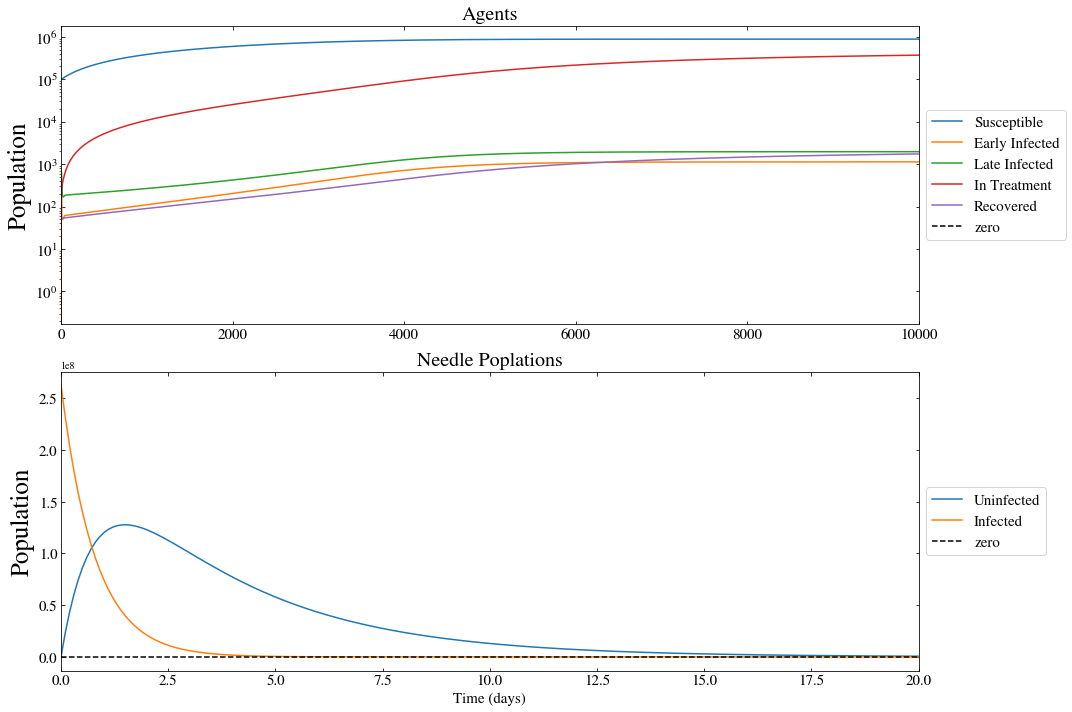

In [6]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

fig = p.figure(figsize=[15,10])

time = D

ax1 = p.subplot(2, 1, 2)
p.plot(t,Nu,label='Uninfected')
p.plot(t,Ni,label='Infected')
p.plot(t,np.zeros(N),'k--',label='zero')

p.tick_params(axis='both',direction='in',top=1,right=1,labelsize=15)
p.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
p.xlabel('Time (days)',fontsize=15)
p.xlim(0,20)

p.ylabel('Population',fontsize=25)
ax1.set_title('Needle Poplations',fontsize=20)



ax2 = p.subplot(2,1,1)
p.semilogy(t,S,label='Susceptible')
p.semilogy(t,IE,label='Early Infected')
p.semilogy(t,IL,label='Late Infected')
p.plot(t,T,label='In Treatment')
p.plot(t,R,label='Recovered')
p.plot(t,np.zeros(N),'k--',label='zero')

p.tick_params(axis='both',direction='in',top=1,right=1,labelsize=15)
p.legend(loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
p.xlim(0,time)

p.ylabel('Population',fontsize=25)
ax2.set_title('Agents',fontsize=20)

p.xlim(0,time)


p.tight_layout()


### The Tornado Diagram

c 1.1613865007873208 1.050513616280547
gamma 1.1613865007873208 1.050513616280547
zeta 1.1613865007873208 1.050513616280547
beta 1.1613865007873208 1.050513616280547
Ku 1.1613865007873208 1.050513616280547
piS 1.1613865007873208 1.050513616280547
piN 1.0558059098066555 1.16723735142283
mu 1.0557578297743435 1.1672905131612759
phi 1.0623020838251427 1.1586359776636426
epsln 1.0674512512769905 1.1520597713087806
Ki 1.094354514691127 1.1207960420648582
tau 1.1000359265453057 1.1147886291435514


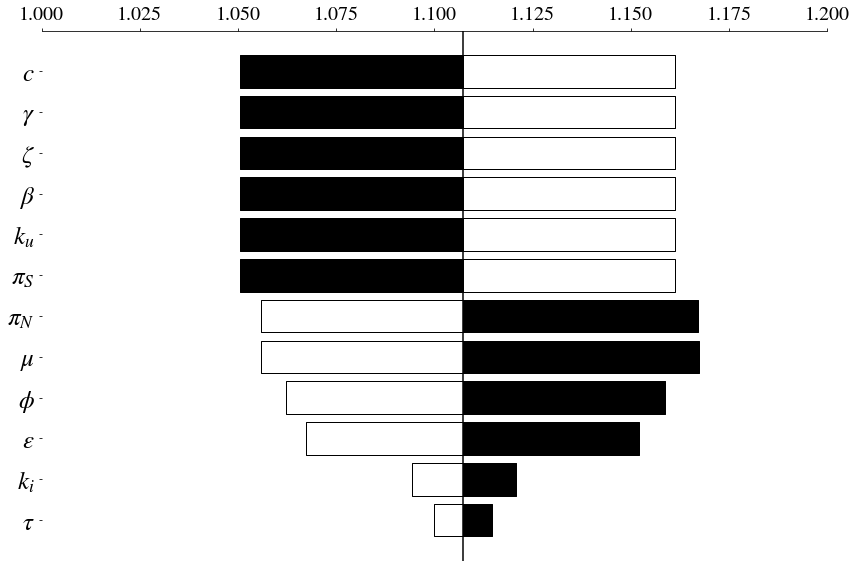

In [7]:
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

# the value of Ro calculated from the chosen parameters
base = np.sqrt(c * gamma * zeta * beta * Ku * piS  / (piN * mu * (mu + tau + phi) * (epsln + Ki)))

varbls = {'c':'$c$' , 'gamma':'$\gamma$' , 'zeta':r'$\zeta$' , 'beta':r'$\beta$' , 'Ku':'$k_u$' , 'piS':'$\pi_S$' , 'piN':'$\pi_N$' , 'mu':'$\mu$' , 'phi':'$\phi$' , 'epsln':'$\epsilon$' , 'Ki':'$k_i$', 'tau':r'$\tau$'}
R0_str = 'np.sqrt(c * gamma * zeta * beta * Ku * piS  / (piN * mu * (mu + tau + phi) * (epsln + Ki)))'
lows = []
highs = []

for each in varbls:
    R0_up = R0_str.replace(each,'1.1*%s' %each)
    R0_down = R0_str.replace(each,'0.9*%s' %each)
    prog = 'R0_up,R0_down = %s,%s' %(R0_up,R0_down)
    exec(prog)
    lows.append(R0_up - base)
    highs.append(R0_down - base)
    
    

# Drawing the plot--------------------------------------------------------------------

fig = plt.figure(figsize=[12,8])

# The y position for each variable
ys = range(len(varbls))[::-1]  # top to bottom

# Plot the bars, one by one
for var, y, low, high in zip(varbls,ys, lows, highs):
    print(var,low+base,high+base)
    
    # Each bar is a "broken" horizontal bar chart
    if (low + base) < base:
         # The width of the 'low' and 'high' pieces
        low_width = -low
        high_width = high
        plt.broken_barh(
        [(base + low,low_width), (base, high_width)],
        (y - 0.4, 0.8),
        facecolors=['white', 'black'],  # Try different colors if you like
        edgecolors=['black', 'black'],
        linewidth=1,
        )
    else:
        low_width = low
        high_width = -high
        plt.broken_barh(
        [(base, low_width),(base + high, high_width)],
        (y - 0.4, 0.8),
        facecolors=['white', 'black'],  # Try different colors if you like
        edgecolors=['black', 'black'],
        linewidth=1,
        )

    # Display the value as text. It should be positioned in the center of
    # the 'high' bar, except if there isn't any room there, then it should be
    # next to bar instead. Comment in if want numbers included
    
#     x = base + high_width / 2
#     if x <= base + 50:
#         x = base + high_width + 50
#     plt.text(x, y, str(value), va='center', ha='center')

# Draw a vertical line down the middle
plt.axvline(base, color='black')

# Position the x-axis on the top, hide all the other spines (=axis lines)
axes = plt.gca()  # (gca = get current axes)
axes.spines['left'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.xaxis.set_ticks_position('top')

# Make the y-axis display the variables
plt.yticks(ys, varbls.values(),fontsize=25)

plt.xticks(fontsize=20)

# title
# plt.suptitle('$R_0$ Uncertainty',fontsize=25,fontname='Times New Roman')

# Set the portion of the x- and y-axes to show
plt.xlim(1,1.2)
plt.ylim(-1, len(varbls))

p.tight_layout()



### $R_0$ Contours

<ipython-input-8-20a3d4da218e>:14: RuntimeWarning: divide by zero encountered in true_divide
  Z = np.sqrt( c * gamma * zeta * beta * Ku * piS / (Y * mu * (mu + tau + phi) * (epsln + X) ) )


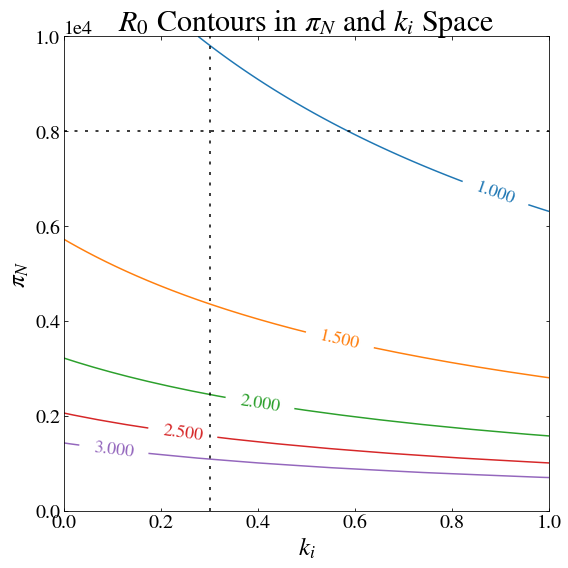

In [8]:
# Ro contours with piN and ki  (i.e. needle birth rate and infected needle discard rate)

import numpy as np
import matplotlib.cm as cm

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

x = np.linspace(0,1,100)           # k axis
y = np.linspace(0,1*10**4,100)     # piN axis

X,Y = np.meshgrid(x,y)

Z = np.sqrt( c * gamma * zeta * beta * Ku * piS / (Y * mu * (mu + tau + phi) * (epsln + X) ) ) 
    
fig, ax = p.subplots(figsize=[8,8])

p.plot(np.linspace(0,1,2),piN * np.ones(2),dashes=[2,5],color='k')
p.plot(Ki * np.ones(2),np.linspace(0,10000,2),dashes=[2,5],color='k')

CS = ax.contour(X, Y, Z,[1,1.5,2,2.5,3],colors=('C0','C1','C2','C3','C4'))
ax.clabel(CS, inline=1, fontsize=18,manual=[(0.1,0.1*10**4),(0.6,0.5*10**4),(0.4,0.2*10**4),(0.25,0.2*10**4),(0.9,0.7*10**4)])

p.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
p.xlabel('$k_i$',fontsize=25)
p.ylabel('$\pi_N$',fontsize=25)
ax.set_title('$R_0$ Contours in $\pi_N$ and $k_i$ Space',fontsize=30)
p.tick_params(labelsize=20,axis='both',direction='in',top=1,right=1)
ax.yaxis.get_offset_text().set_fontsize(20)
p.tight_layout()




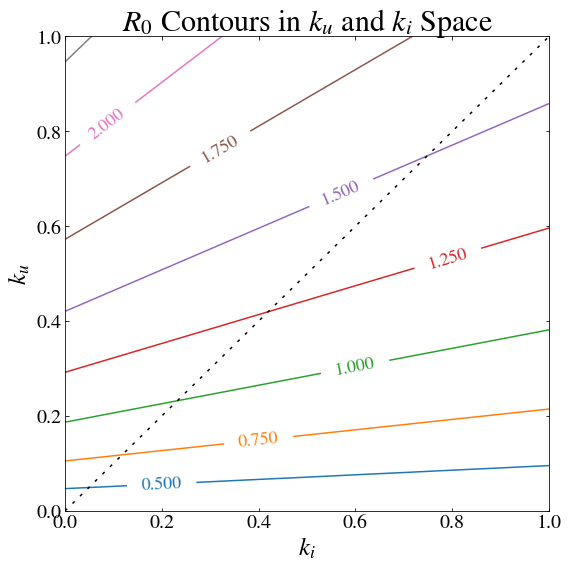

In [9]:
# Ro contours with ku and ki (uninfected and infected discard rates, respectively)

import numpy as np
import matplotlib.cm as cm

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

x = np.linspace(0,1,100)           # ki axis
y = np.linspace(0,1,100)           # ku axis

X,Y = np.meshgrid(x,y)

Z = np.sqrt( c * gamma * zeta * beta * Y * piS / (piN * mu * (mu + tau + phi) * (epsln + X) ) ) 
    
fig, ax = p.subplots(figsize=[8,8])


p.plot(np.linspace(0,1,2),np.linspace(0,1,2),dashes=[2,5],color='k')
# p.plot(0.114379 * np.ones(2),np.linspace(0,0.114379,2),dashes=[2,5],color='k')
# p.plot(np.linspace(0,0.114379,2),0.114379 * np.ones(2),dashes=[2,5],color='k')

CS = ax.contour(X, Y, Z,[0.5,0.75,1,1.25,1.5,1.75,2,2.25],colors=('C0','C1','C2','C3','C4','C5','C6','C7'))
ax.clabel(CS, inline=1, fontsize=18, manual=[(0.2,0.05),(0.4,0.15),(0.6,0.3),(0.8,0.5),(0.6,0.6),(0.3,0.8),(0.1,0.8)])

p.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
p.xlabel('$k_i$',fontsize=25)
p.ylabel('$k_u$',fontsize=25)
ax.set_title('$R_0$ Contours in $k_u$ and $k_i$ Space',fontsize=30)
p.tick_params(labelsize=20,axis='both',direction='in',top=1,right=1)
p.tight_layout()



### $R_0$ PRCC calculation

In [10]:
from pyDOE import *
from scipy.stats import uniform
import pylab as p
from numpy.linalg import inv
import numpy as np
import matplotlib as mpl

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

R0 = lambda q : np.sqrt(q[0] * q[1] * q[2] * q[3] * q[4] * q[5]  / (q[6] * q[7] * (q[7] + q[11] + q[8]) * (q[9] + q[10])))

# the dictionary below gives (mean,stdev) for each parameter
params = {'c':(c,0.5),'gamma':(gamma,2),'zeta':(zeta,0.1),'beta':(beta,0.005),'Ku':(Ku,0.2),'piS':(piS,100),'piN':(piN,3000),'mu':(mu,0.00005),'phi':(phi,0.05),'epsln':(epsln,0.03),'Ki':(Ki,0.2),'tau':(tau,0.02)}                                                                                   
means = [x[0] for x in params.values()]
stdvs = [x[1] for x in params.values()]

# R0 PRCC

k = 12
N = 100

Mu = (1+N)/2   # average rank

the_gammas = []


for s in range(50): # repeated lhs sampling (over 100 samples) 50 times
    lhd = lhs(k,N)

    for i in range(k):                                  # this maps lhs choices to a normal dist using the normal dist cdf
        lhd[:, i] = uniform(means[i]-stdvs[i],2 * stdvs[i]).ppf(lhd[:, i])

    r = []
    for j in range(k):
        x = lhd[:,j]
        seq = sorted(x)
        r.append([1+seq.index(v) for v in x])

    r = np.array(r).T

    R0_lhd = [R0(lhd[j,:]) for j in range(N)]
    seq = sorted(R0_lhd)
    R = [1+seq.index(v) for v in R0_lhd]     


    C = np.zeros([k+1,k+1])    # initializes the matrix C

    for i in range(k):
        for j in range(k):
            rij = [(r[v,i] - Mu) * (r[v,j] - Mu) for v in range(N)]
            rii = [(r[v,i] - Mu)**2 for v in range(N)]
            rjj = [(r[v,j] - Mu)**2 for v in range(N)]
            C[i,j] = sum(rij)/np.sqrt(sum(rii) * sum(rjj))

    for i in range(k):
        rij = [(r[v,i] - Mu) * (R[v] - Mu) for v in range(N)]
        rii = [(r[v,i] - Mu)**2 for v in range(N)]
        rjj = [(R[v] - Mu)**2 for v in range(N)]
        C[i,k] = sum(rij)/np.sqrt(sum(rii) * sum(rjj))
        C[k,i] = sum(rij)/np.sqrt(sum(rii) * sum(rjj))

    C[k,k] = 1

    B = inv(C)

    gammas = [-B[i,k]/np.sqrt(B[i,i] * B[k,k]) for i in range(k)]

    the_gammas.append(gammas)

### PRCC plot (averaged over 50 iterations)

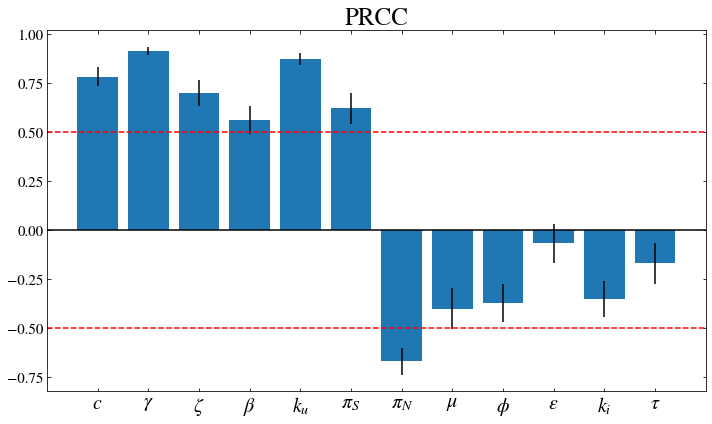

In [11]:
# the below dictionary maps paraters to their formatted string labels for the plot
varbls = {'c':'$c$' , 'gamma':'$\gamma$' , 'zeta':r'$\zeta$' , 'beta':r'$\beta$' , 'Ku':'$k_u$' , 'piS':'$\pi_S$' , 'piN':'$\pi_N$' , 'mu':'$\mu$' , 'phi':'$\phi$' , 'epsln':'$\epsilon$' , 'Ki':'$k_i$', 'tau':r'$\tau$'}
labels = varbls.values()
prcc_means = []     # this holds the average PRCC values for each paramter
prcc_errs = []      # this holds the standard deviations of the PRCC values for each paramter

for each in params:
    i = list(params.keys()).index(each)
    PRCCs = [the_gammas[j][i] for j in range(len(the_gammas))] 
    prcc_means.append(np.mean(PRCCs))
    prcc_errs.append(np.std(PRCCs))
#     print(each,' ',mean(PRCCs),std(PRCCs))   # to inspect the values
    

# this bar-graph shows the results along with the error bars
fig,ax = p.subplots(figsize=[10,6])
ax.bar(labels,prcc_means,yerr=prcc_errs)
ax.plot(np.linspace(-1,13,2),0.5*np.ones(2),'r--')
ax.plot(np.linspace(-1,13,2),-0.5*np.ones(2),'r--')
ax.plot(np.linspace(-1,13,2),np.zeros(2),'k')
p.tick_params(labelsize=20,axis='x',direction='in',top=1,right=1)
p.tick_params(labelsize=15,axis='y',direction='in',top=1,right=1)
p.title('PRCC',fontsize=25)
p.xlim(-1,12)
p.tight_layout()


### Plotting the $N_u$ and $N_i$ equilibria as a function of $k$

(0.0, 1.0)

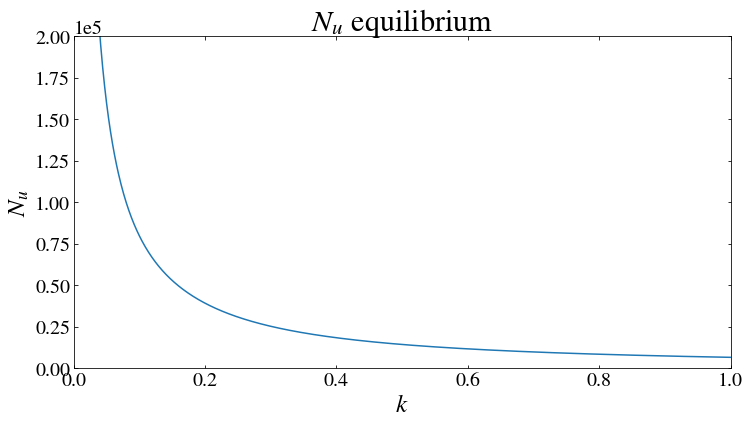

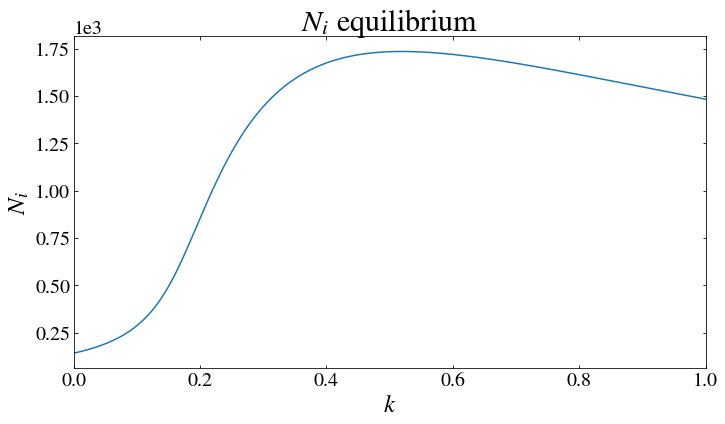

In [13]:
# Nu and Ni equilibria as a fnc of k 
import matplotlib.cm as cm


mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

x = np.linspace(0.001,1,1000)           # Nu and Ni axis
    
fig,ax = p.subplots(figsize=[10,6])

data_u = np.loadtxt('NuArray.csv')   
data_i = np.loadtxt('NiArray.csv')

p.plot(x,data_u,label='$N_u$')     # Nu

p.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
p.xlabel('$k$',fontsize=25)
p.ylabel('$N_u$',fontsize=25)
p.title('$N_u$ equilibrium',fontsize=30)
p.tick_params(labelsize=20,axis='both',direction='in',top=1,right=1)
ax.yaxis.get_offset_text().set_fontsize(20)
p.tight_layout()
p.xlim(0,1)
p.ylim(0,2*10**5)



fig,ax = p.subplots(figsize=[10,6])

p.plot(x,data_i,label='$N_i$')     # Ni

p.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
p.xlabel('$k$',fontsize=25)
p.ylabel('$N_i$',fontsize=25)
p.title('$N_i$ equilibrium',fontsize=30)
p.tick_params(labelsize=20,axis='both',direction='in',top=1,right=1)
ax.yaxis.get_offset_text().set_fontsize(20)
p.tight_layout()
p.xlim(0,1)





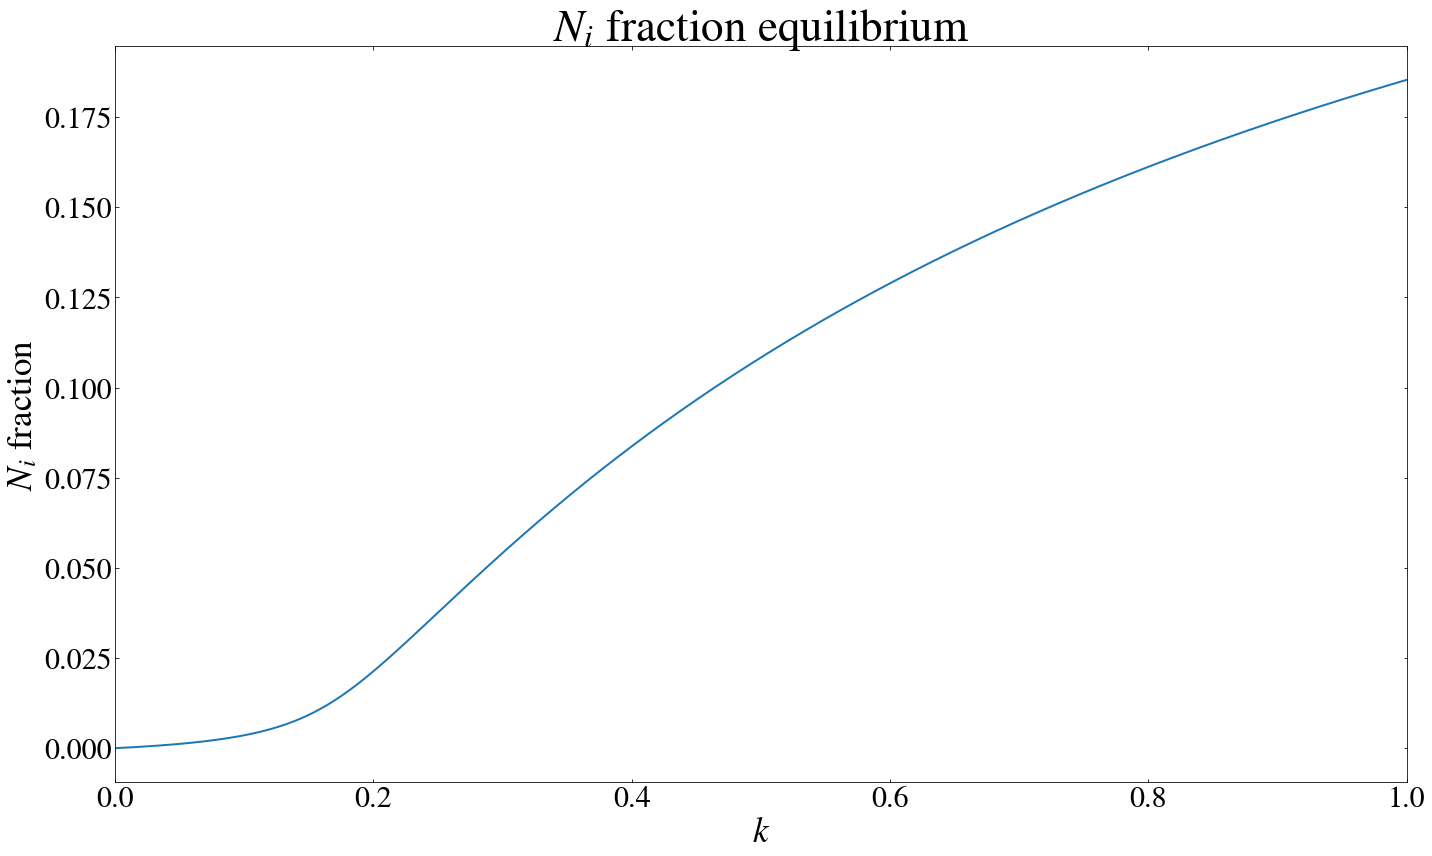

In [15]:
# Ni Fraction equilibria as a fnc of k 
import numpy as np
from scipy.integrate import odeint
import matplotlib as mpl
import pylab as p
import os

os.chdir('C:/Users/user/Desktop')   # sets the cwd to C:/.../HCV


mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

x = np.linspace(0.001,1,1000)           # Nu and Ni axis


fig,ax = p.subplots(figsize=[20,12])

data_iFrac = np.loadtxt('NiFracArray.csv')

p.plot(x,data_iFrac,linewidth=2)             # Ni Fraction

p.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
p.xlabel('$k$',fontsize=35)
p.ylabel('$N_i$ fraction',fontsize=35)
p.title('$N_i$ fraction equilibrium',fontsize=45)
p.tick_params(labelsize=30,axis='both',direction='in',top=1,right=1)
p.ticklabel_format(style='plain')
p.xlim(0,1)
p.tight_layout()



